Import packages

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output  # this has to be removed if used on a single script
import random
from preprocess import preprocess_seismo, preprocess_coord
from scipy.ndimage.interpolation import shift
import GPy
import time
from sklearn.decomposition import PCA

# PCA compression

Define auxiliary functions

In [2]:
def next_batch(x, y, mb_size):
    idx = np.arange(len(x), dtype = np.int64)
    np.random.shuffle(idx)
    idx = idx[:mb_size]
    return x[idx], y[idx], idx

def plot(x, index=0):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(x, label='Reconstructed')
    plt.plot(X_data[index], label='Real')
    plt.legend()

def plot_test(x, index=0):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(x, label='Reconstructed')
    plt.plot(X_data_test[index], label='Real')
    plt.legend()

def calculate_R2(original, prediction, label, store):
    AM = original.mean()
    BM = prediction.mean()
    c_vect = (original-AM)*(prediction-BM)
    d_vect = (original-AM)**2
    e_vect = (prediction-BM)**2
    r_out = np.sum(c_vect)/float(np.sqrt(np.sum(d_vect)*np.sum(e_vect)))
    print(label+str(r_out))
    store.append(r_out)

Define number of time components in seismograms, number of coordinates, train/test split and load data

In [3]:
X_dim = 501 # size of the seismograms
y_dim = 4
# load data
split = 2000
test_valid = 1000
X_data_ = np.load('./seismograms_4000seismo_ISO.npy')[:, :X_dim]
y_data_ = np.load('./coordinates_4000seismo_ISO.npy')

In [4]:
#start_time = time.time()

In [5]:
# preprocess coordinates
y_data_preprocessed, meancoords, stdcoords = preprocess_coord(y_data_, split=split, test_valid=test_valid, sort=False, std=True)
y_data = y_data_preprocessed[:split]
y_data_valid =  y_data_preprocessed[split:split+test_valid]
y_data_test =  y_data_preprocessed[split+test_valid:]

Shifted and standardized; not sorted
Mean: [-1.49500000e-01  6.00000000e-02 -1.23196500e+02  1.29906166e+02], std dev: [23.03473789 23.21808347 68.8275736  64.09918073]


In [7]:
# preprocess seismograms
X_data_preprocessed = preprocess_seismo(X_data_, split, log=False, std=False, rescale=True, rescale_onlyamp=False)
X_data = X_data_preprocessed[:split]
X_data_valid =  X_data_preprocessed[split:split+test_valid]
X_data_test =  X_data_preprocessed[split+test_valid:]

Amplitude of first peak in reference seismo 4476.40283203125
Time index of first peak in reference seismo 204
Saving amplitude ratios and shift indices
Rescaling only.


In [8]:
# save rescaled amplitudes and time shift indices on file
amplitude_rescale = np.loadtxt('./amplitude_rescale_NOTsorted.txt')
shift_index = np.loadtxt('./shift_index_NOTsorted.txt')

Standardise data before PCA

In [10]:
# we standardise data to apply PCA
meanseismo = np.mean(X_data, axis=0)
stdseismo = np.std(X_data, axis=0)
X_data = (X_data - meanseismo)/stdseismo
X_data_valid = (X_data_valid - meanseismo)/stdseismo
X_data_test = (X_data_test - meanseismo)/stdseismo

# number of PCA components
selected_comp = 20

pca = PCA(n_components=selected_comp)
pca.fit(X_data)
basis = pca.components_
dominantseismo_train = pca.transform(X_data)
dominantseismo_valid = pca.transform(X_data_valid)
#dominantseismo_test = pca.transform(X_data_test)
        
seismo = np.matmul(dominantseismo_train, basis)
seismo_valid = np.matmul(dominantseismo_valid, basis)
#seismo_test = dominantseismo_test @ basis

In [11]:
# standardise the PCA components before feeding them into NN
mean = np.mean(dominantseismo_train)
std = np.std(dominantseismo_train)
dominantseismo_train = (dominantseismo_train - mean)/std
dominantseismo_valid = (dominantseismo_valid - mean)/std
#dominantseismo_test = (dominantseismo_test - mean)/std

# NN training

In [12]:
# define network
mb_size = 256 # batch size
act_f = getattr(tf.nn, 'leaky_relu') #parametric_relu #getattr(tf.nn, 'leaky_relu') # activation function
lr = 1e-4

tf.reset_default_graph() #this will eliminate the variables we restored
X = tf.placeholder(tf.float32, shape=[None, X_dim])
c = tf.placeholder(tf.float32, shape=[None, y_dim])
z = tf.placeholder(tf.float32, shape=[None, selected_comp])
bsize = tf.placeholder(tf.int32)

h_dim = 50

In [13]:
def latent_P(coord):
    h1 = tf.layers.dense(coord, h_dim, activation=act_f)
    h2 = tf.layers.dense(h1, h_dim, activation=act_f)
    h3 = tf.layers.dense(h2, h_dim, activation=act_f)
    logits = tf.layers.dense(h3, selected_comp)
    return logits

z_nn_samples = latent_P(c)

# reconstruction loss
recon_loss_nn = tf.keras.losses.MSE(z, z_nn_samples)

# loss
loss_nn = tf.reduce_mean(recon_loss_nn)

solver_nn = tf.train.AdamOptimizer().minimize(loss_nn)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [14]:
saver = tf.train.Saver(max_to_keep=None)

In [15]:
sess = tf.Session()

In [16]:
sess.run(tf.global_variables_initializer())

Epoch: 99
Rec loss: 0.8616
Validation rec loss: 0.6458
Early stopping: 15/100


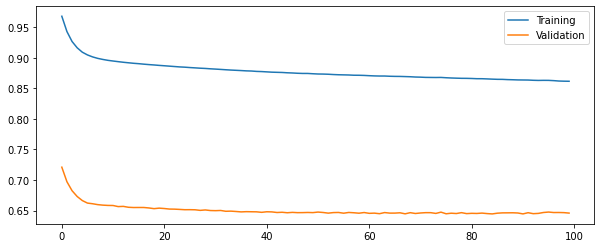

In [17]:
losses_rec_nn = []
valid_losses_rec_nn = []

training_nn_R2 = []
validation_nn_R2 = []
test_nn_R2 = []

n_epochs = 100 # number of epochs
best_loss = 1e8
stopping_step = 0
patience = 100

for epoch in range(n_epochs):
    
    # train
    random_perm = np.random.permutation(dominantseismo_train.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index+mb_size]
        sess.run(solver_nn, feed_dict={z: dominantseismo_train[indices], c: y_data[indices]})
        mini_batch_index += mb_size
        if mini_batch_index >= X_data.shape[0]:
            break

    # metrics
    clear_output(wait=True)

    rec = sess.run(recon_loss_nn, feed_dict={z: dominantseismo_train, c: y_data})
    valid_rec = sess.run(recon_loss_nn, feed_dict={z: dominantseismo_valid, c: y_data_valid})

    losses_rec_nn.append(np.mean(rec))
    valid_losses_rec_nn.append(np.mean(valid_rec))

    print('Epoch: {}'.format(epoch))
    print('Rec loss: {:.4}'.format(np.mean(rec)))
    print('Validation rec loss: {:.4}'.format(np.mean(valid_rec)))
        
    # we only look at the z reconstruction, as we integrate PCA later on
    #X_R2, y_R2, _ = next_batch(dominantseismo_train, y_data, split)
    #prediction_training = sess.run(z_nn_samples, feed_dict={c: y_R2})
    #calculate_R2(X_R2, prediction_training, 'Training NN ', training_nn_R2)

    #prediction_valid = sess.run(z_nn_samples, feed_dict={c: y_data_valid})
    #calculate_R2(dominantseismo_valid, prediction_valid, 'Validation NN: ', validation_nn_R2)

    #prediction_test = sess.run(z_nn_samples, feed_dict={c: y_data_test})
    #calculate_R2(dominantseismo_test, prediction_test, 'Test NN: ', test_nn_R2)

    loss_value = np.mean(valid_rec)
    if loss_value < best_loss:
        stopping_step = 0
        best_loss = loss_value
        save_path = saver.save(sess, "./PCA_plus_NN/best_model.ckpt")
    else:
        stopping_step += 1
        print('Early stopping: {}/{}'.format(stopping_step, patience))
    if stopping_step >= patience:
        print('Patience limit reached at epoch {}'.format(epoch))
        break
        
fig = plt.figure(figsize=(10, 4))
plt.plot(losses_rec_nn, label='Training')        
plt.plot(valid_losses_rec_nn, label='Validation')        
plt.legend()
plt.show()

In [18]:
# load best model
#print('Best model was model {}'.format(len(losses_rec_nn) - patience))
load_path = ("./saved_models_iso_PCAplusNN/best_model.ckpt")
saver.restore(sess, load_path)

INFO:tensorflow:Restoring parameters from ./saved_models_iso_PCAplusNN/best_model.ckpt


# GP training for Amplitude and Time shifts

In [9]:
# reshape for GP training
amplitude_rescale_train = amplitude_rescale[:split].reshape(X_data.shape[0], 1)
amplitude_rescale_valid = amplitude_rescale[split:split+test_valid]
amplitude_rescale_test = amplitude_rescale[split+test_valid:]

shift_index_train = shift_index[:split].reshape(X_data.shape[0], 1)
shift_index_valid = shift_index[split:split+test_valid]
shift_index_test = shift_index[split+test_valid:]

In [19]:
# fit GP to data rescaling
# amplitude
kern = GPy.kern.Matern32(4,ARD=True)
n = GPy.models.GPRegression(y_data, amplitude_rescale_train, kern)
n.optimize(messages=True, max_f_eval = 1000)

y_pred_train = n.predict(y_data)[0]
y_pred_train = y_pred_train[:, 0]
calculate_R2(amplitude_rescale_train.flatten(), y_pred_train, 'Amplitude R2 train: ', [])

y_pred_valid = n.predict(y_data_valid)[0]
y_pred_valid = y_pred_valid[:, 0]
calculate_R2(amplitude_rescale_valid, y_pred_valid, 'Amplitude R2 validation: ', [])

# this is to be used later
y_pred_test = n.predict(y_data_test)[0]
y_pred_test = y_pred_test[:, 0]

#plt.plot(amplitude_rescale_test, color='blue')
#plt.show()
#plt.plot(y_pred_test, color='red')
#plt.show()

Amplitude R2 train: 0.9974162627385389
Amplitude R2 validation: 0.9916612696530922


In [29]:
# time shift
ker = GPy.kern.Matern32(4,ARD=True)
m = GPy.models.GPRegression(y_data,shift_index_train,ker)
m.optimize(messages=True,max_f_eval = 1000)

y_pred_train_2 = m.predict(y_data)[0]
y_pred_train_2 = y_pred_train_2[:, 0]
calculate_R2(shift_index_train.flatten(), y_pred_train_2, 'Time shift R2 training: ', [])

y_pred_valid_2 = m.predict(y_data_valid)[0]
y_pred_valid_2 = y_pred_valid_2[:, 0]
calculate_R2(shift_index_valid, y_pred_valid_2, 'Time shift R2 validation: ', [])

y_pred_test_2 = m.predict(y_data_test)[0]
y_pred_test_2 = y_pred_test_2[:, 0]

#plt.plot(shift_index_test, color='blue')
#plt.show()
#plt.plot(y_pred_test_2, color='red')
#plt.show()

 /home/alessio/anaconda2/envs/seismoml/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/alessio/anaconda2/envs/seismoml/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/alessio/anaconda2/envs/seismoml/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/alessio/anaconda2/envs/seismoml/lib/python3.7/site-packages/GPy/kern/src/stationary.py:468: RuntimeWarning:invalid value encountered in multiply
 /home/alessio/anaconda2/envs/seismoml/lib/python3.7/site-packages/GPy/kern/src/stationary.py:471: RuntimeWarning:invalid value encountered in multiply


Time shift R2 training: 0.9977940055828869
Time shift R2 validation: 0.9988501704645588


In [30]:
# obtain reconstructed seismo for the test set
prediction_z_test = sess.run(z_nn_samples, feed_dict={c: y_data_test})
prediction_z_test = prediction_z_test*std + mean
prediction_testing = prediction_z_test@basis
prediction_testing = prediction_testing*stdseismo+meanseismo

prediction_testing = np.multiply(prediction_testing, np.repeat(1/y_pred_test, X_dim).reshape(-1, X_dim))

for index_seism in range(test_valid):
    prediction_testing[index_seism] = shift(prediction_testing[index_seism], -y_pred_test_2[index_seism], cval=0.)

# retrieve the unprocessed data back
X_data_preprocessed = preprocess_seismo(X_data_, split, log=False, std=False, rescale=False, rescale_onlyamp=False)
X_data_test = X_data_preprocessed[split+test_valid:]

calculate_R2(X_data_test, prediction_testing, 'Final R2 testing: ', [])

#for i in range(5):
#    plt.plot(X_data_test[i], color='blue')
#    plt.plot(prediction_testing[i], color='red')
#    plt.show()

(1000, 4)
(1000, 501)
(1000, 501)
(1000, 501)
No preprocessing step done.
Final R2 testing: 0.7558589647121761


In [ ]:
# # total time, to be quoted in the paper
# print("--- %s seconds ---" % (time.time() - start_time))

# Inference

In [21]:
ker = GPy.kern.Matern32(4,ARD=True) 
m_load = GPy.models.GPRegression(y_data, amplitude_rescale_train, ker, initialize=False)
m_load.update_model(False) # do not call the underlying expensive algebra on load
m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
m_load[:] = np.load('./saved_models_iso_PCAplusNN/GPmodel_amplitude.npy') # Load the parameters
m_load.update_model(True) # Call the algebra only once

kern = GPy.kern.Matern32(4,ARD=True) 
n_load = GPy.models.GPRegression(y_data, shift_index_train, kern, initialize=False)
n_load.update_model(False) # do not call the underlying expensive algebra on load
n_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
n_load[:] = np.load('./saved_models_iso_PCAplusNN/GPmodel_time.npy') # Load the parameters
n_load.update_model(True) # Call the algebra only once

 /home/alessio/anaconda2/envs/seismoml/lib/python3.7/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


In [22]:
start_time_inference = time.time()

coordinate = np.array([31,25,158])

shifted = coordinate - np.array([41,41,244])
distances = np.linalg.norm(shifted)
new_coords = np.zeros(4)
new_coords[:3] = shifted
new_coords[-1] = distances
new_coords = (new_coords - meancoords)/stdcoords
new_coords = new_coords.reshape((1,y_dim))

prediction_z_test = sess.run(z_nn_samples, feed_dict={c: new_coords})
prediction_z_test = prediction_z_test*std + mean
prediction_testing = np.matmul(prediction_z_test,basis)
prediction_testing = prediction_testing*stdseismo+meanseismo
y_pred_test = m_load.predict(new_coords)[0]
y_pred_test = y_pred_test[:, 0]
y_pred_test_2 = n_load.predict(new_coords)[0]
y_pred_test_2 = y_pred_test_2[:, 0]
prediction_testing = np.multiply(prediction_testing, np.repeat(1/y_pred_test, X_dim).reshape(-1, X_dim))
prediction_testing = shift(prediction_testing[0], -y_pred_test_2, cval=0.)

timeinf = time.time() - start_time_inference
print("timeinf", timeinf)
np.save("PCA_plus_NN_inftime.npy", timeinf)

timeinf 0.025774717330932617
